# EDA

In [159]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')

### Load datasets

In [160]:
directory = "/Users/rnirms/Documents/omdena/data/CPCB_downloads/2023-03-07/csv_latest/"

all_files = os.listdir(directory)

# Filter the list to include only .xlsx files
csv_files = [file for file in all_files if file.endswith(".csv")]

# Print the list
print(csv_files)

['BandraKurlaComplexMumbaiIITM.csv', 'SiddharthNagarWorliMumbaiIITM.csv', 'BandraMumbaiMPCB.csv', 'BorivaliEastMumbaiIITM.csv', 'VasaiWestMumbaiMPCB.csv', 'KhindipadaBhandupWestMumbaiIITM.csv', 'NavyNagarColabaMumbaiIITM.csv', 'BorivaliEastMumbaiMPCB.csv', 'ChhatrapatiShivajiIntlAirportT2MumbaiMPCB.csv', 'ChakalaAndheriEastMumbaiIITM.csv', 'WorliMumbaiMPCB.csv', 'SionMumbaiMPCB.csv', 'MaladWestMumbaiIITM.csv', 'VileParleWestMumbaiMPCB.csv', 'DeonarMumbaiIITM.csv', 'PowaiMumbaiMPCB.csv', 'ColabaMumbaiMPCB.csv', 'KandivaliEastMumbaiMPCB.csv', 'MazgaonMumbaiIITM.csv', 'MulundWestMumbaiMPCB.csv', 'KurlaMumbaiMPCB.csv']


### Get single station data (KurlaMumbaiMPCB)

In [162]:
df = pd.read_csv(os.path.join(directory, csv_files[-1]))
df.head()

,Unnamed: 0,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,...,Eth-Benzene,MP-Xylene,RH,WS,WD,SR,BP,AT,TOT-RF,Unnamed: 23
0,1,01-01-2021 00:00,01-01-2021 00:15,150,330.21,92.03,25.09,117.14,38.31,37.22,...,23.3,0.59,68.43,0.59,156.02,None,None,23.1,0,NaN
1,2,01-01-2021 00:15,01-01-2021 00:30,150,398,101.03,23.89,124.94,37.9,38.6,...,21.85,0.68,69.3,0.5,189.3,None,None,22.74,0,NaN
2,3,01-01-2021 00:30,01-01-2021 00:45,150,398,113.79,22.28,136.06,36.74,40.23,...,31.43,None,71.45,0.49,238.31,None,None,22.77,0,NaN
3,4,01-01-2021 00:45,01-01-2021 01:00,164.42,398,126.27,22.24,148.53,28.61,36.52,...,27.64,11.98,76.18,0.73,292.77,None,None,22.53,0,NaN
4,5,01-01-2021 01:00,01-01-2021 01:15,209,459.16,131.9,22.61,154.51,24.13,33.75,...,11.9,32.39,80.07,0.53,248.84,None,None,22.19,0,NaN


Remove columns: Unnamed:0, From Date, Unnamed:23

In [163]:
df = df.iloc[:, 2:-1]

In [164]:
df.columns

Index(['To Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'AT', 'TOT-RF'],
      dtype='object')

Check datatypes.

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76321 entries, 0 to 76320
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   To Date      76321 non-null  object
 1   PM2.5        76321 non-null  object
 2   PM10         76321 non-null  object
 3   NO           76321 non-null  object
 4   NO2          76321 non-null  object
 5   NOx          76321 non-null  object
 6   NH3          76321 non-null  object
 7   SO2          76321 non-null  object
 8   CO           76321 non-null  object
 9   Ozone        76321 non-null  object
 10  Benzene      76321 non-null  object
 11  Toluene      76321 non-null  object
 12  Eth-Benzene  76321 non-null  object
 13  MP-Xylene    76321 non-null  object
 14  RH           76321 non-null  object
 15  WS           76321 non-null  object
 16  WD           76321 non-null  object
 17  SR           76321 non-null  object
 18  BP           76321 non-null  object
 19  AT           76321 non-nu

Convert date to `datetime` format. 

In [166]:
df = df.rename(columns={'To Date': 'Date'}) # Rename date column
df["Date"] = pd.to_datetime(df.Date, format='%d-%m-%Y %H:%M')

In [167]:
df.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,Toluene,Eth-Benzene,MP-Xylene,RH,WS,WD,SR,BP,AT,TOT-RF
0,2021-01-01 00:15:00,150,330.21,92.03,25.09,117.14,38.31,37.22,2.61,6.09,...,None,23.3,0.59,68.43,0.59,156.02,None,None,23.1,0
1,2021-01-01 00:30:00,150,398,101.03,23.89,124.94,37.9,38.6,2.37,2.39,...,None,21.85,0.68,69.3,0.5,189.3,None,None,22.74,0
2,2021-01-01 00:45:00,150,398,113.79,22.28,136.06,36.74,40.23,2.38,7.27,...,None,31.43,None,71.45,0.49,238.31,None,None,22.77,0
3,2021-01-01 01:00:00,164.42,398,126.27,22.24,148.53,28.61,36.52,2.16,5.37,...,None,27.64,11.98,76.18,0.73,292.77,None,None,22.53,0
4,2021-01-01 01:15:00,209,459.16,131.9,22.61,154.51,24.13,33.75,1.78,2.4,...,None,11.9,32.39,80.07,0.53,248.84,None,None,22.19,0


Convert other columns to `float`. 

In [168]:
df = df.replace('None', np.NaN)
df[df.columns[1:]] = df[df.columns[1:]].astype(float)

### Check missing values

In [169]:
begin_date = list(df['Date'])[0]
end_date = list(df['Date'])[-1]
print(f'Data date range: {begin_date} to {end_date}')

Data date range: 2021-01-01 00:15:00 to 2023-03-07 00:00:00


Sanity check: What should be the total number of rows in this dataset?

In [170]:
n_per_hour = 4
n_per_day = n_per_hour * 24
days = (365 + 366 + (30+28+6)) 
total_rows = days * n_per_day + 1 # 1 extra entry for 2023-03-07 00:00:00
total_rows

76321

In [171]:
len(df)

76321

In [172]:
missing_values = 100 * df.isnull().sum()/len(df)
print(missing_values)

Date             0.000000
PM2.5           29.335307
PM10            40.152776
NO              27.512742
NO2             31.193250
NOx             27.335858
NH3             28.927818
SO2             35.038849
CO              34.018160
Ozone           35.096500
Benzene         24.256758
Toluene        100.000000
Eth-Benzene     30.975747
MP-Xylene       31.004573
RH              28.633011
WS              28.633011
WD              28.633011
SR              65.224512
BP              73.794893
AT              28.845272
TOT-RF           0.000000
dtype: float64


In [173]:
missing_values = missing_values.to_frame().reset_index().T
missing_values.columns = missing_values.iloc[0] #use top row as column header
missing_values = missing_values[1:] #remove top row

In [174]:
missing_values

index,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,Toluene,Eth-Benzene,MP-Xylene,RH,WS,WD,SR,BP,AT,TOT-RF
0,0.0,29.335307,40.152776,27.512742,31.19325,27.335858,28.927818,35.038849,34.01816,35.0965,...,100.0,30.975747,31.004573,28.633011,28.633011,28.633011,65.224512,73.794893,28.845272,0.0


Where is the 30% of missing values for PM2.5?

<AxesSubplot: >

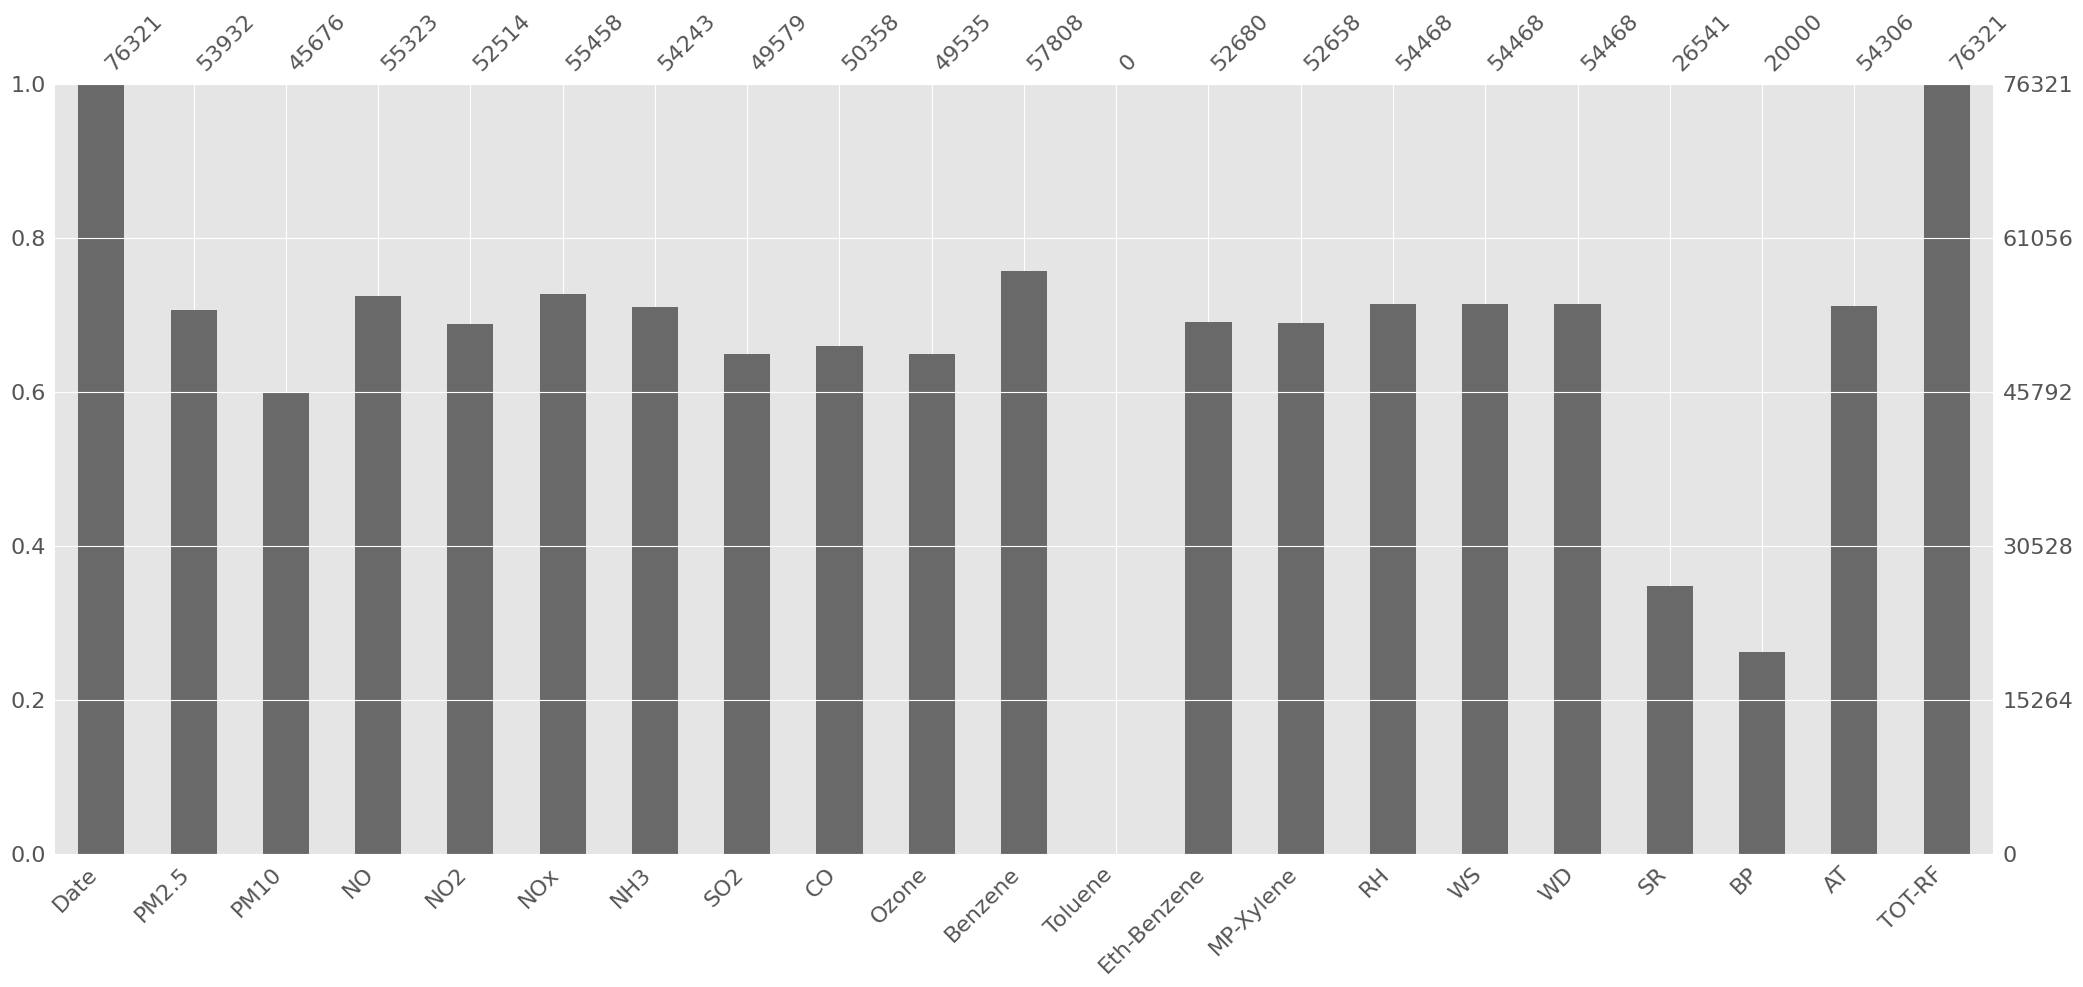

In [177]:
import missingno as msno

msno.bar(df)

<AxesSubplot: >

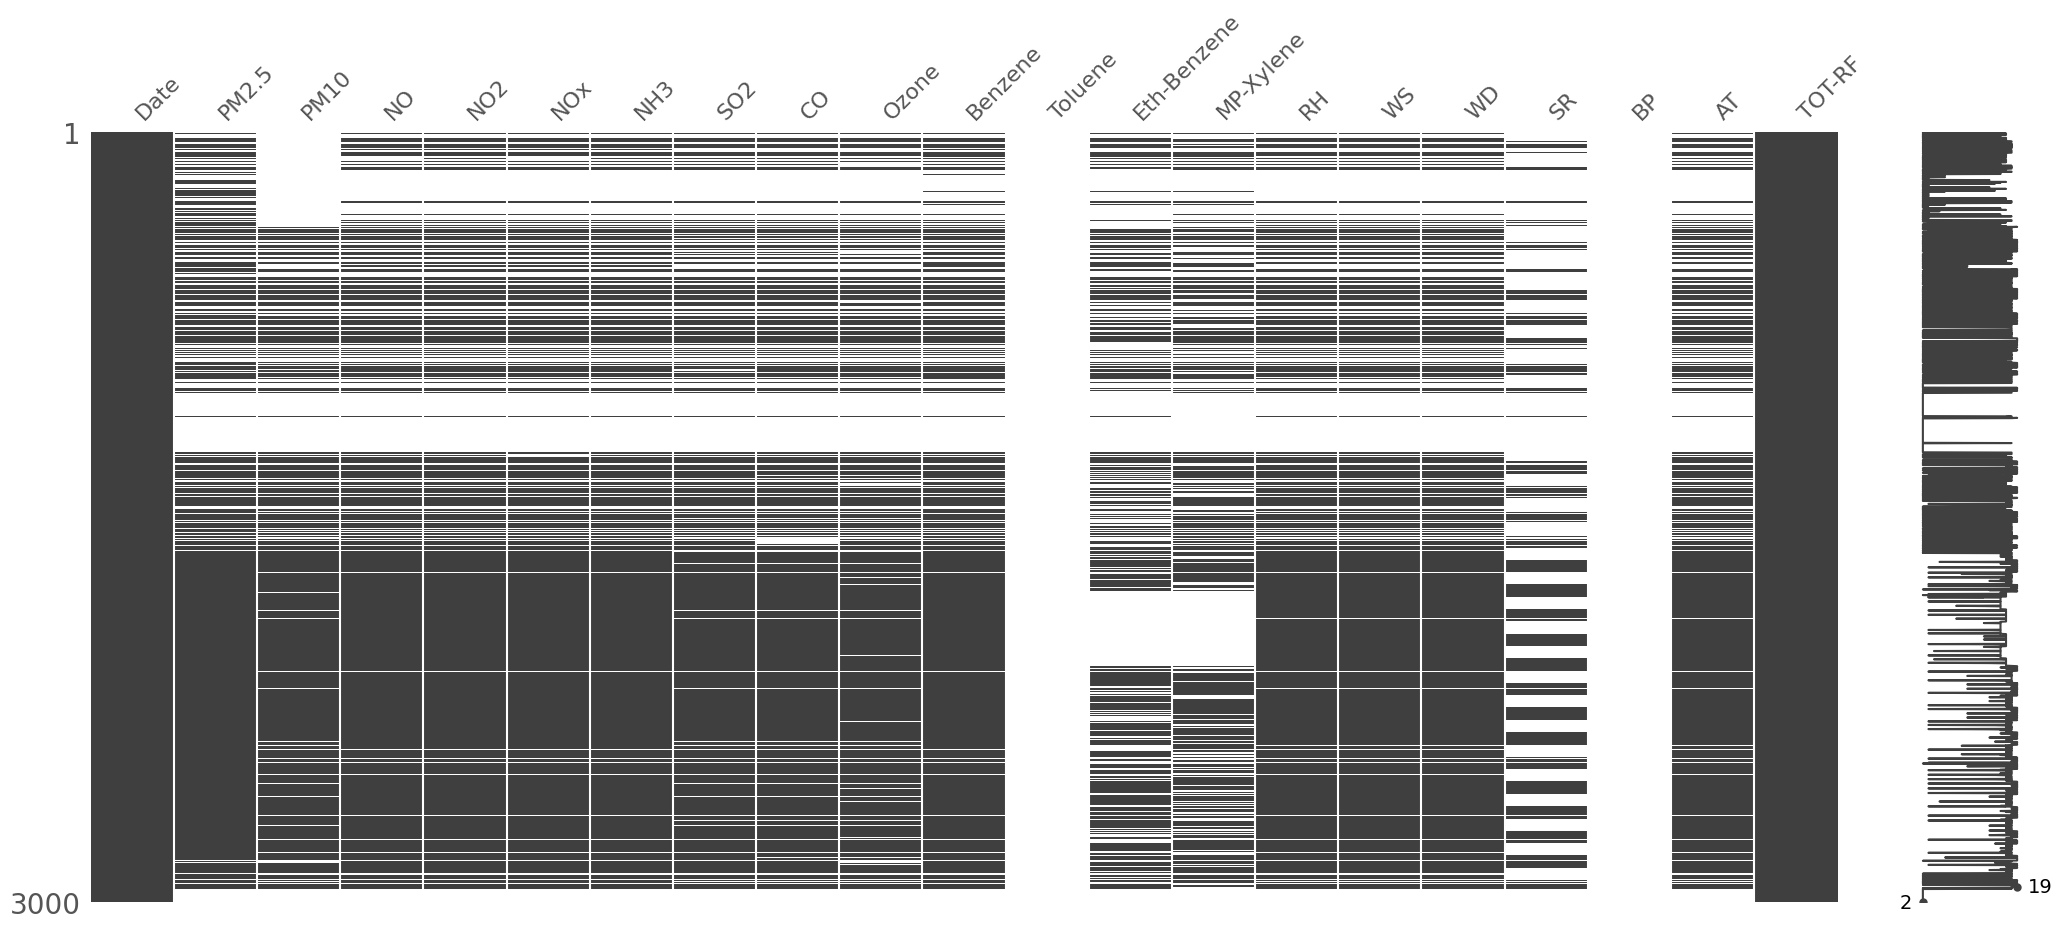

In [228]:
plt.rcParams['figure.figsize']=(20,6)

msno.matrix(df[7000:10000])

In [187]:
df[1:100]

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,Toluene,Eth-Benzene,MP-Xylene,RH,WS,WD,SR,BP,AT,TOT-RF
1,2021-01-01 00:30:00,150.00,398.00,101.03,23.89,124.94,37.90,38.60,2.37,2.39,...,NaN,21.85,0.68,69.30,0.50,189.30,NaN,NaN,22.74,0.0
2,2021-01-01 00:45:00,150.00,398.00,113.79,22.28,136.06,36.74,40.23,2.38,7.27,...,NaN,31.43,NaN,71.45,0.49,238.31,NaN,NaN,22.77,0.0
3,2021-01-01 01:00:00,164.42,398.00,126.27,22.24,148.53,28.61,36.52,2.16,5.37,...,NaN,27.64,11.98,76.18,0.73,292.77,NaN,NaN,22.53,0.0
4,2021-01-01 01:15:00,209.00,459.16,131.90,22.61,154.51,24.13,33.75,1.78,2.40,...,NaN,11.90,32.39,80.07,0.53,248.84,NaN,NaN,22.19,0.0
5,2021-01-01 01:30:00,209.00,742.00,134.56,21.05,155.63,30.63,32.33,1.56,1.19,...,NaN,11.50,33.59,82.12,0.46,264.99,NaN,NaN,21.88,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2021-01-02 00:00:00,170.25,293.00,73.32,20.43,93.75,21.15,35.79,1.59,5.09,...,NaN,8.46,13.32,76.20,0.52,184.22,NaN,NaN,24.19,0.0
96,2021-01-02 00:15:00,186.00,304.57,75.12,21.48,96.59,23.34,34.95,1.53,6.10,...,NaN,17.10,26.67,76.74,0.51,208.32,NaN,NaN,24.10,0.0
97,2021-01-02 00:30:00,186.00,355.00,77.98,21.43,99.42,28.92,35.33,1.49,3.18,...,NaN,22.13,13.09,77.49,0.70,226.55,NaN,NaN,23.99,0.0
98,2021-01-02 00:45:00,186.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### Checking Outliers

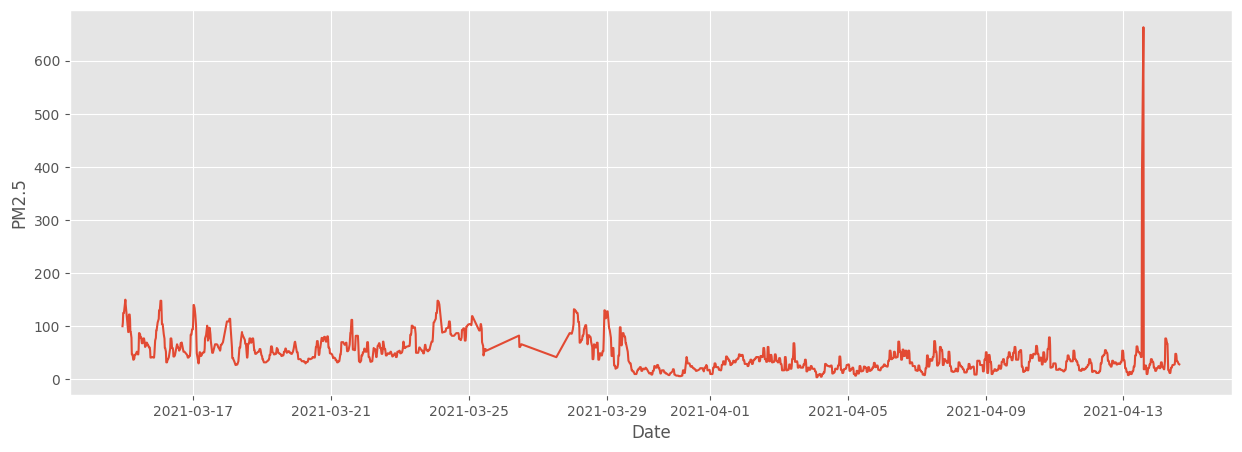

In [227]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(15, 5))
 
# drawing the plot
# Plot the responses for different events and regions

graph = sns.lineplot(x="Date", y="PM2.5", ax=ax, data=df[7000:10000])


<AxesSubplot: xlabel='Date'>

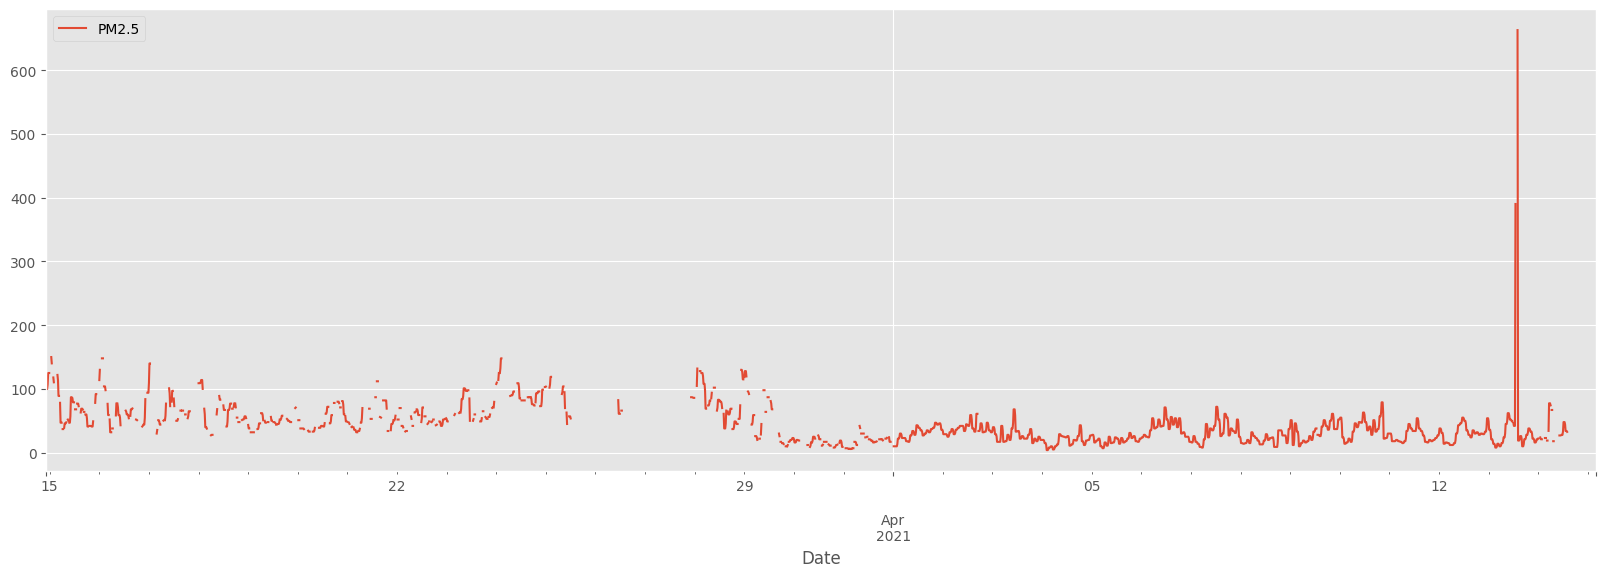

In [226]:
df[['Date','PM2.5']][7000:10000].set_index('Date').plot()

### Missing data for all stations 

1. Get dataframes for all stations in a list 

In [129]:
df_list = []
station_names = []
for filename in csv_files: 
    df_temp = pd.read_csv(os.path.join(directory, filename))
    df_list.append(df_temp)
    name, _ = os.path.splitext(filename)
    station_names.append(name)

In [21]:
len(df_list)

21

In [130]:
station_names

['BandraKurlaComplexMumbaiIITM',
 'SiddharthNagarWorliMumbaiIITM',
 'BandraMumbaiMPCB',
 'BorivaliEastMumbaiIITM',
 'VasaiWestMumbaiMPCB',
 'KhindipadaBhandupWestMumbaiIITM',
 'NavyNagarColabaMumbaiIITM',
 'BorivaliEastMumbaiMPCB',
 'ChhatrapatiShivajiIntlAirportT2MumbaiMPCB',
 'ChakalaAndheriEastMumbaiIITM',
 'WorliMumbaiMPCB',
 'SionMumbaiMPCB',
 'MaladWestMumbaiIITM',
 'VileParleWestMumbaiMPCB',
 'DeonarMumbaiIITM',
 'PowaiMumbaiMPCB',
 'ColabaMumbaiMPCB',
 'KandivaliEastMumbaiMPCB',
 'MazgaonMumbaiIITM',
 'MulundWestMumbaiMPCB',
 'KurlaMumbaiMPCB']

In [152]:
mv_data = pd.DataFrame()
for data in df_list:
    data = data.iloc[:, 2:-1] # Remove columns: Unnamed:0, From Date, Unnamed:23
    data = data.rename(columns={'To Date': 'Date'}) # Rename date column
    data["Date"] = pd.to_datetime(data.Date, format='%d-%m-%Y %H:%M') # Format Date column as datetime
    data = data.replace('None', np.NaN) # Replace all 'None' to NaN
    data[data.columns[1:]] = data[data.columns[1:]].astype(float) # Format all other columns to float 

    missing_values = data.isnull().sum()/len(data)
    missing_values = missing_values.to_frame().reset_index().T
    missing_values.columns = missing_values.iloc[0] #use top row as column header
    missing_values = missing_values[1:] #remove top row

    mv_data = pd.concat([mv_data, missing_values], ignore_index=True) # Add to the missing values table 
    

In [153]:
mv_data = mv_data.replace(np.NaN, 1)

In [154]:
mv_data

index,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,WS,WD,SR,BP,Xylene,AT,RF,TOT-RF,Temp,VWS
0,0.0,0.284655,0.288460,0.325283,0.318222,0.316914,0.322955,0.319438,0.286015,0.289075,...,0.268336,0.266636,1.000000,0.263341,0.262282,0.440667,0.262909,0.0,1.000000,1.000000
1,0.0,0.110179,0.111306,0.194887,0.159615,0.152435,0.173059,1.000000,0.112996,0.125483,...,0.121133,0.119941,1.000000,0.119980,1.000000,0.651131,0.999961,1.0,1.000000,1.000000
2,0.0,0.678287,0.659835,0.737766,0.723793,0.736220,1.000000,0.671503,0.692678,0.753729,...,0.663620,0.663476,0.684978,0.779356,1.000000,1.000000,0.651101,0.0,0.664942,0.663842
3,0.0,0.372165,0.360196,0.377560,0.379511,0.378437,0.375412,1.000000,0.325664,0.310382,...,0.509848,0.300796,1.000000,0.299369,1.000000,1.000000,0.299827,1.0,1.000000,1.000000
4,0.0,0.301896,0.576932,0.148963,0.136018,0.129139,0.214004,0.179597,0.172914,0.793307,...,0.149159,0.149107,1.000000,0.756358,1.000000,0.151282,1.000000,0.0,1.000000,1.000000
5,0.0,0.065316,0.067164,0.127580,0.057677,0.124697,0.130816,0.155698,0.099841,0.166271,...,0.762765,0.762909,1.000000,0.873141,0.054441,0.998768,0.727598,0.0,1.000000,1.000000
6,0.0,0.167949,0.170084,0.324681,0.343287,0.303730,0.315012,0.310452,0.126374,0.131943,...,0.296537,0.120648,1.000000,0.817888,0.405079,0.151334,0.119312,0.0,1.000000,1.000000
7,0.0,0.259517,0.369947,0.309514,0.323709,0.308675,0.309985,0.492634,0.437059,0.415714,...,0.389563,0.389511,0.844078,0.837452,1.000000,0.392732,1.000000,0.0,1.000000,1.000000
8,0.0,0.121303,0.052502,0.199434,0.214305,0.195831,0.238768,0.155776,0.167123,0.150850,...,0.206994,0.206876,0.998795,0.402851,1.000000,0.209051,1.000000,0.0,1.000000,1.000000
9,0.0,0.154587,0.156485,0.240241,0.241406,0.239730,0.243423,0.147830,0.131304,0.203536,...,0.118209,0.123643,1.000000,0.914372,0.401715,1.000000,0.111111,0.0,0.738624,1.000000


In [155]:
mv_data['StationName'] = station_names

In [156]:
mv_data = mv_data.set_index('StationName')

In [157]:
mv_data

index,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,WS,WD,SR,BP,Xylene,AT,RF,TOT-RF,Temp,VWS
StationName,,,,,,,,,,,,,,,,,,,,,
BandraKurlaComplexMumbaiIITM,0.0,0.284655,0.288460,0.325283,0.318222,0.316914,0.322955,0.319438,0.286015,0.289075,...,0.268336,0.266636,1.000000,0.263341,0.262282,0.440667,0.262909,0.0,1.000000,1.000000
SiddharthNagarWorliMumbaiIITM,0.0,0.110179,0.111306,0.194887,0.159615,0.152435,0.173059,1.000000,0.112996,0.125483,...,0.121133,0.119941,1.000000,0.119980,1.000000,0.651131,0.999961,1.0,1.000000,1.000000
BandraMumbaiMPCB,0.0,0.678287,0.659835,0.737766,0.723793,0.736220,1.000000,0.671503,0.692678,0.753729,...,0.663620,0.663476,0.684978,0.779356,1.000000,1.000000,0.651101,0.0,0.664942,0.663842
BorivaliEastMumbaiIITM,0.0,0.372165,0.360196,0.377560,0.379511,0.378437,0.375412,1.000000,0.325664,0.310382,...,0.509848,0.300796,1.000000,0.299369,1.000000,1.000000,0.299827,1.0,1.000000,1.000000
VasaiWestMumbaiMPCB,0.0,0.301896,0.576932,0.148963,0.136018,0.129139,0.214004,0.179597,0.172914,0.793307,...,0.149159,0.149107,1.000000,0.756358,1.000000,0.151282,1.000000,0.0,1.000000,1.000000
KhindipadaBhandupWestMumbaiIITM,0.0,0.065316,0.067164,0.127580,0.057677,0.124697,0.130816,0.155698,0.099841,0.166271,...,0.762765,0.762909,1.000000,0.873141,0.054441,0.998768,0.727598,0.0,1.000000,1.000000
NavyNagarColabaMumbaiIITM,0.0,0.167949,0.170084,0.324681,0.343287,0.303730,0.315012,0.310452,0.126374,0.131943,...,0.296537,0.120648,1.000000,0.817888,0.405079,0.151334,0.119312,0.0,1.000000,1.000000
BorivaliEastMumbaiMPCB,0.0,0.259517,0.369947,0.309514,0.323709,0.308675,0.309985,0.492634,0.437059,0.415714,...,0.389563,0.389511,0.844078,0.837452,1.000000,0.392732,1.000000,0.0,1.000000,1.000000
ChhatrapatiShivajiIntlAirportT2MumbaiMPCB,0.0,0.121303,0.052502,0.199434,0.214305,0.195831,0.238768,0.155776,0.167123,0.150850,...,0.206994,0.206876,0.998795,0.402851,1.000000,0.209051,1.000000,0.0,1.000000,1.000000


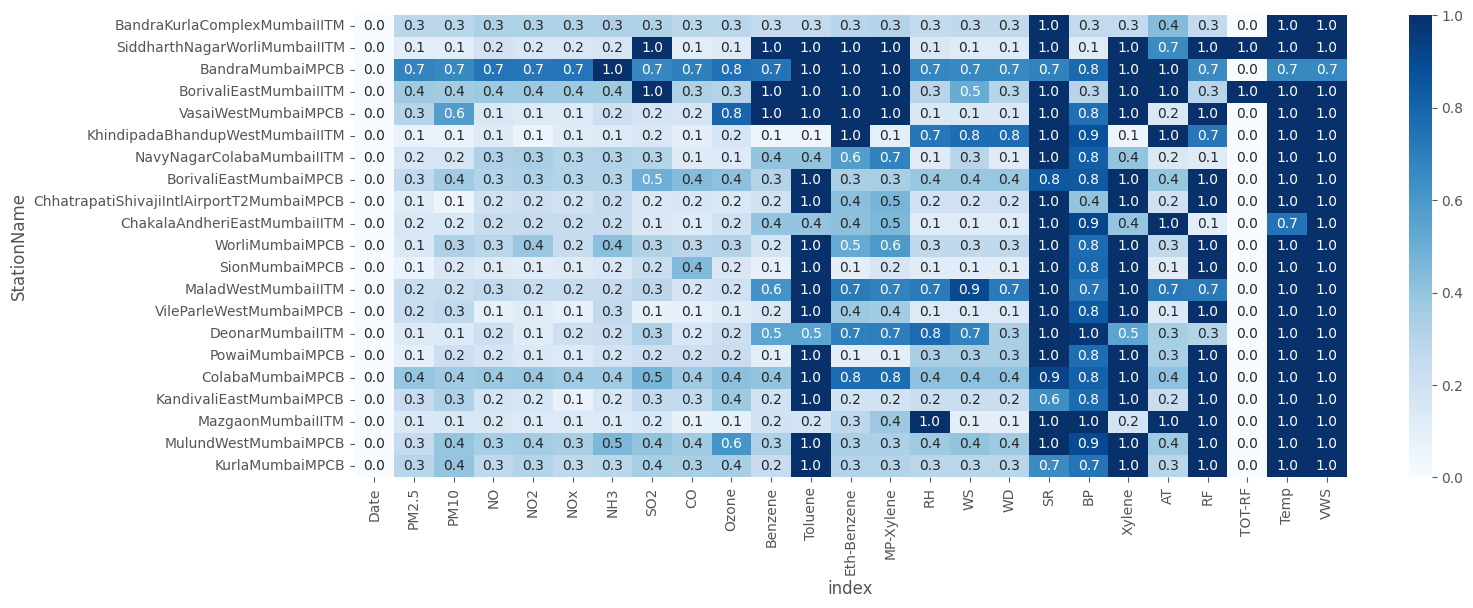

In [158]:
# Create the heatmap
sns.heatmap(mv_data, annot=True, cmap='Blues', fmt='.1f')

# Show the plot
plt.show()

## Imputation 

Ref: https://www.kaggle.com/code/juejuewang/handle-missing-values-in-time-series-for-beginners

To decide on the best imputation strategy, mask out some values from the original data, and impute them. Find the mean square error between the ground truth data and the imputed data. The strategy that gives the lowest MSE can be chosen. 

Note, the final decision will be based on model performance. This is an ad-hoc method until we start modelling.

### Create a masked dataset 

In [320]:
df_pm25 = df[['Date', 'PM2.5']].copy()

Missing data visualised for a sample

<AxesSubplot: xlabel='Date'>

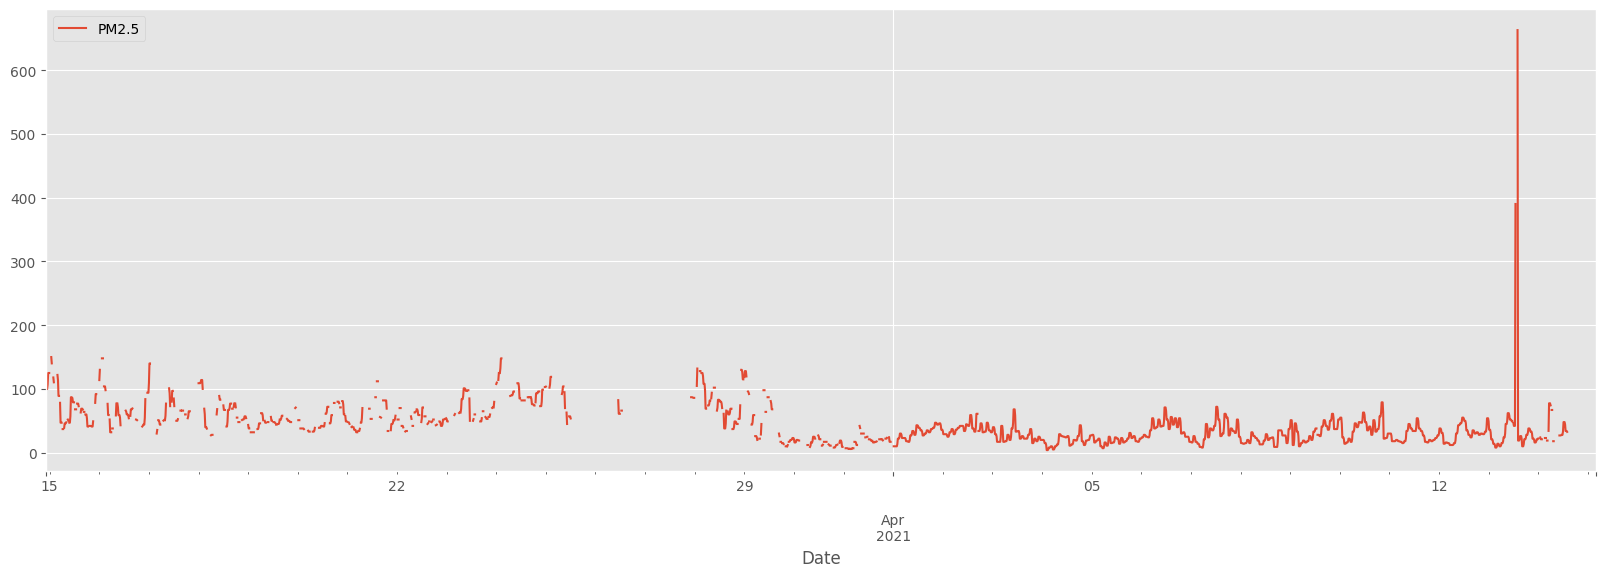

In [321]:
df_pm25[7000:10000].set_index('Date').plot()

Randomly set 10% of data as missing.

In [324]:
# get the list of indices of non-empty rows 
res = np.where(np.isnan(df['PM2.5']) == False)[0]

In [325]:
len(res)

53932

In [326]:
import random 
res_mask = random.sample(list(res), int(0.1*len(res)))

In [328]:
df_pm25_masked = df_pm25.copy()


In [329]:
df_pm25_masked.loc[res_mask, 'PM2.5'] = np.NaN

### Median Imputation

In [330]:
import numpy as np 
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')

In [331]:
col_pm = df_pm25_masked['PM2.5'].values.reshape(-1, 1)

In [332]:
imputed_col_pm = imp.fit_transform(col_pm)

In [333]:
len(imputed_col_pm)

76321

In [334]:
df_pm25_imputed = df_pm25_masked.copy()
df_pm25_imputed.loc[:,'PM2.5'] = imputed_col_pm

<AxesSubplot: xlabel='Date'>

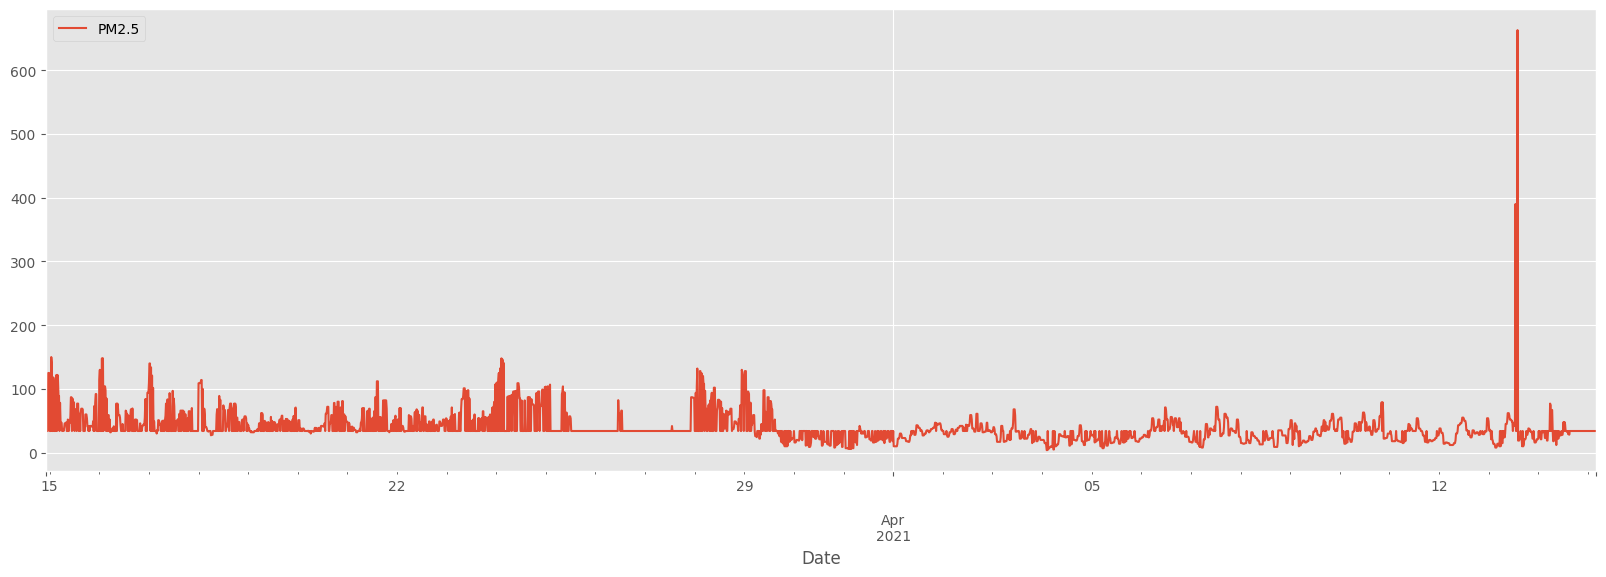

In [335]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [336]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']

In [338]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(x1, x2)


In [339]:
mse

1633.2034161691083

### Mean Imputation

In [340]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_col_pm = imp.fit_transform(col_pm)
df_pm25_imputed.loc[:,'PM2.5'] = imputed_col_pm

In [341]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

1451.8340388543938

### LOCF (Last Observation Carry Forward) or Forward Fill Imputation

In [342]:
gfg1 = df_pm25_masked.ffill()

<AxesSubplot: xlabel='Date'>

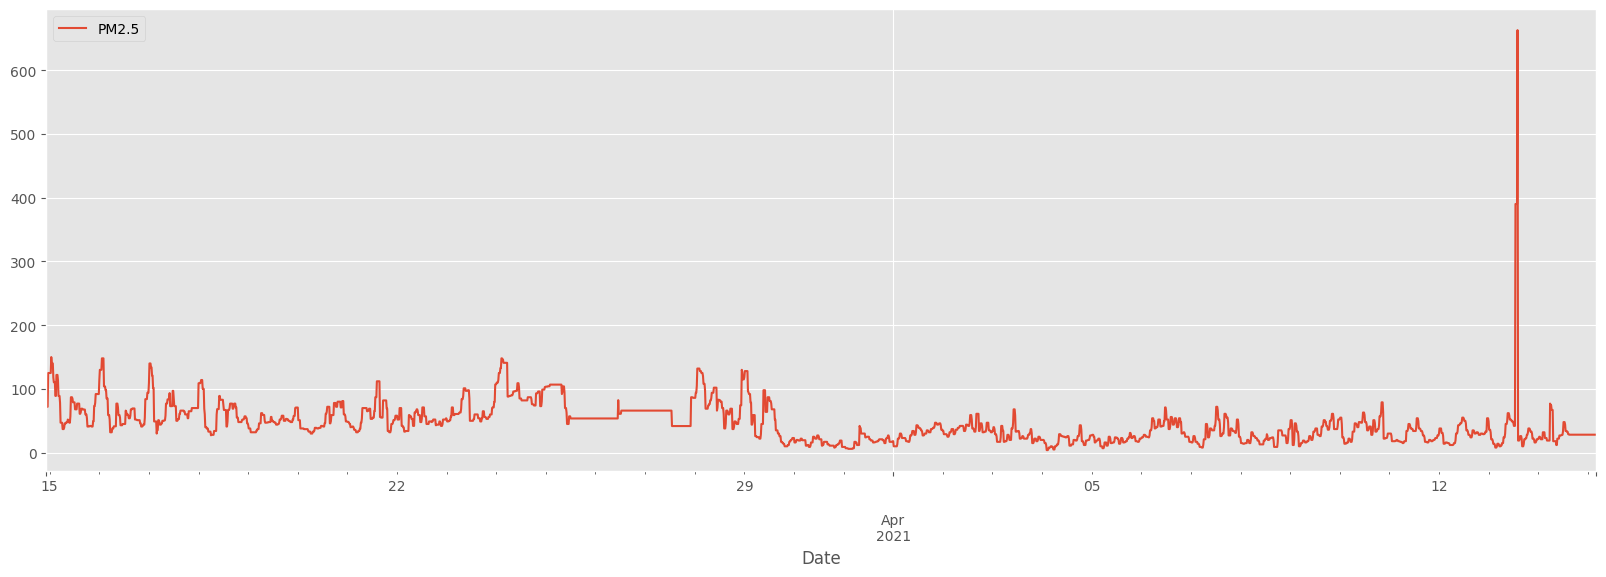

In [345]:
gfg1[7000:10000].set_index('Date').plot()

In [346]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = gfg1.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

217.58759278694603

### NOBF (Next Observation Bring Forward) or Backward Fill Imputation

In [347]:
gfg2 = df_pm25_masked.bfill()

<AxesSubplot: xlabel='Date'>

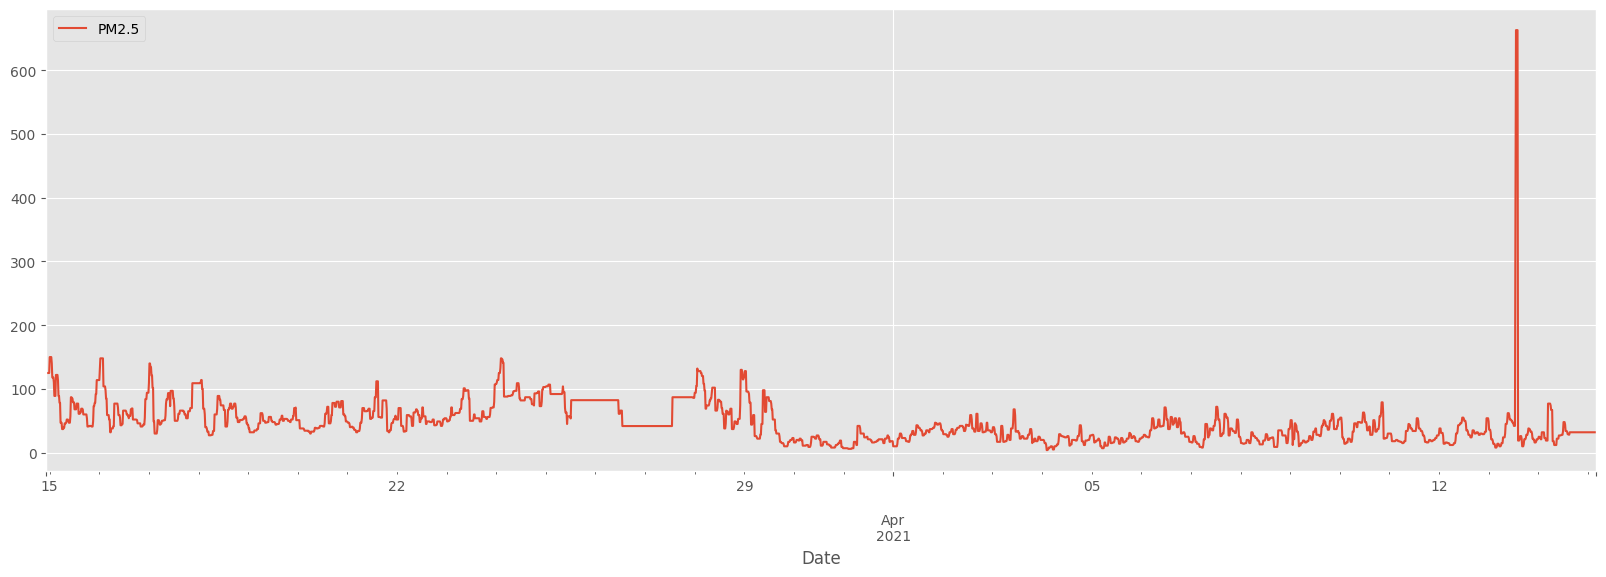

In [348]:
gfg2[7000:10000].set_index('Date').plot()

In [349]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = gfg2.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

259.04405525681443

The least MSE is with forward fill method. 

### Linear interpolation (Work in progress)

In [352]:
df_pm25_masked.interpolate(method='linear')

ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear

TO DO: 
* Missing data: 
    * Characterise type of missing data - entire station down OR only 1 sensor down OR down for 1 reading OR sensor down for a long period
* Outliers: 
    * Why are maximum values above 500 for PM2.5? 
    * Show box plots for each pollutant across stations 